# Pair Optimization

GLD-GDX:  0.499
GLD-SLV:  0.533
theta_star, mu_star, sigma_star, mle:  0.5462487824193807 14.772816105702846 0.16669619339699665 3.166379414388735
theta_star, mu_star, sigma_star, mle:  0.5703964727189397 33.21373311361346 0.14182491352717347 3.3633917986670787


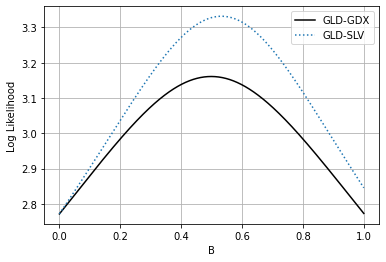

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# Ornstein-Uhlenbeck process is not just stationary but also normally distributed
# ou parameter : dXt = mu(theta - Xt)dt + sigma * dBt
#      - Bt : standard Brownian motion under the probability measure P
#      - mu : deterministic part & the drift of the process, mean-reversion rate
#      - sigma : control the random process 
#      - θ : long-term mean, θ ∈ R
#      - If sigma is large enough, then mu become unsignificant for the process


# Source of Mathmatical Calculation
# https://www.ubs.com/global/en/investment-bank/in-focus/research-focus/quant-answers/quant-insight-series/_jcr_content/mainpar/toplevelgrid_7262680_322968126/col1/actionbutton_3358030.1305440028.file/PS9jb250ZW50L2RhbS9pbnRlcm5ldGhvc3RpbmcvaW52ZXN0bWVudGJhbmsvZW4vZXF1aXRpZXMvcWlzLXZpcnR1YWwtZXZlbnQtZGVja3MtMjAyMC9tci10cmFkaW5nLXRhbGstdWJzLWFwcmlsLTIwMjEucGRm/mr-trading-talk-ubs-april-2021.pdf
# https://github.com/mghadam/ouparams/blob/main/src/ouparams/ouparams.py
# https://reference.wolfram.com/language/ref/OrnsteinUhlenbeckProcess.html

def get_optimal_ou_params(X, dt): 
    """
    Xx = Σ(i=1, i=n) x(i-1)
    Xy = Σ(i=1, i=n) x(i)
    Xxx = Σ(i=1, i=n) x(i-1)^2
    Xyy = Σ(i=1, i=n) x(i)^2
    Xxy = Σ(i=1, i=n) x(i) * x(i-1)
    
    something uncorrect for finding optimal mu, so we get mu by another way
    """
    n = X.size
    Xx  = np.sum(X[:-1])
    Xy  = np.sum(X[1:])
    Xxx = np.sum(X[:-1]**2)
    Xyy = np.sum(X[1:]**2)
    Xxy = np.sum(X[:-1] * X[1:])
        
    theta_star = ((Xy * Xxx) - (Xx * Xxy))/(n*(Xxx - Xxy) - ((Xx**2) - Xx * Xy)) # Mean
    mu_star = -(1 / dt) * np.log((Xxy - theta_star * Xx - theta_star * Xy + n*theta_star**2)/(Xxx - 2 * theta_star * Xx + n * theta_star**2))    
    alpha = np.exp(-mu_star * dt) # Rate
    sigma_h = np.sqrt((1/n)*(Xyy-(2*alpha*Xxy)+((alpha**2)*Xxx)-(2*theta_star*(1-alpha)*(Xy-alpha*Xx))+(n*(theta_star**2)*(1-alpha)**2)))
    sigma_star = np.sqrt((sigma_h**2)*(2*mu_star/(1-alpha**2)))  # Volatility

    return theta_star, mu_star, sigma_star


"""Inaccurate Result
def fit_ar1(ts: pd.Series, dt:float = 1/252) -> (np.array, float):
    
    # Fit AR(1) process from time series of price
    
    ts_y = ts.values[1:].reshape(-1, 1)
    ts_x = np.append(np.ones(len(ts_y)), ts.values[:-1]).reshape(2,-1).T
    
    phi = np.linalg.inv(ts_x.T @ ts_x) @ ts_x.T @ ts_y
    sigma = np.sqrt(np.sum((ts_y - ts_x @ phi) ** 2) / (len(ts_y)))
    phi = phi.reshape(-1)
    
    theta = phi[0] / (1-phi[1])
    mu = (1-phi[1]) / dt
    sigma = sigma / np.sqrt(dt)
    return theta, mu, sigma
"""

def compose_xt(s1, s2, A, B):
    alpha = A / s1[0]
    beta = B / s2[0]
    return alpha * s1 - beta * s2


# Define the OU probability density function
def f_OU(xi, xi_1, theta, mu, sigma, dt):
    sigma_tilde_squared = sigma**2 * (1 - np.exp(-2 * mu * dt)) / (2 * mu)
    exponent = -(xi - xi_1 * np.exp(-mu * dt) - theta * (1 - np.exp(-mu * dt)))**2 / (2 * sigma_tilde_squared)
    return (1 / np.sqrt(2 * np.pi * sigma_tilde_squared)) * np.exp(exponent)


# Define the average log likelihood
def avg_log_likelihood(params, Xt, dt):
    theta, mu, sigma = params
    n = len(Xt)
    sigma_tilde = np.sqrt(sigma**2 * (1 - np.exp(-2 * mu * dt)) / (2 * mu))
    
    sum_term = sum([(Xt[i] - Xt[i-1] * np.exp(-mu * dt) - theta * (1 - np.exp(-mu * dt)))**2 for i in range(1, n)])
    
    log_likelihood = (-0.5 * np.log(2 * np.pi) - np.log(sigma_tilde) - (1 / (2 * n * sigma_tilde**2)) * sum_term)
    return -log_likelihood

# Same Result
def get_average_log_likelihood(theta, mu, sigma, X, dt):
    sigma_square = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma_tilda = np.sqrt( sigma_square )
    
    N = X.size
    
    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma_tilda)
    
    prefactor = -1 / (2 * N * sigma_tilda**2)
    sum_term = 0
    for i in range(1, N):
        x2 = X[i]
        x1 = X[i-1]
        
        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) - \
                   theta * (1-np.exp(-mu*dt)))**2
    
    f = (term1 + term2 + prefactor * sum_term)
    return f

def adjust_mu_maximizing_avg_log_likelihood(xt, theta, sigma, dt=1/252):
    adjusted_initial_params = [theta, 0.1, sigma]
    bounds = [(-np.inf, np.inf), (0, np.inf), (0, np.inf)]
    # Minimize the negative log likelihood with adjusted initial guesses
    result_adjusted = minimize(avg_log_likelihood, adjusted_initial_params, args=(xt, dt), bounds=bounds, method='L-BFGS-B')

    # Extract the optimized parameters
    theta_opt_adj, mu_opt_adj, sigma_opt_adj = result_adjusted.x

    # Calculate the average log likelihood with optimized parameters
    avg_ll_opt_adj = -avg_log_likelihood([theta_opt_adj, mu_opt_adj, sigma_opt_adj], xt, dt)
    return theta_opt_adj, mu_opt_adj, sigma_opt_adj, avg_ll_opt_adj


def get_mle_table(s1, s2, dt):

    candidate_B = np.linspace(0.001, 1, 1000)
    optimal_params_table = []
    for B in candidate_B:
        X = compose_xt(s1, s2, 1, B)
        theta_star, mu_star, sigma_star = get_optimal_ou_params(X, dt)
        mle = get_average_log_likelihood(theta_star, mu_star, sigma_star, X, dt)
        optimal_params_table.append((theta_star, mu_star, sigma_star, mle, B))

    table = pd.DataFrame(optimal_params_table, columns=['theta', 'mu', 'sigma', 'mle', 'B'])
    return table


def get_B_star(table):
    return float(table.iloc[np.where(table.mle==np.max(table.mle))].B.values)


if __name__ == "__main__":
    # Same example 
    GDX = pd.read_csv('data/GDX_historical.csv')
    GLD = pd.read_csv('data/GLD_historical.csv')
    SLV = pd.read_csv('data/SLV_historical.csv')

    gld = GLD['Adj Close'].to_numpy()
    gdx = GDX['Close'].to_numpy()
    slv = SLV['Close'].to_numpy()

    M = 3
    gld = gld[M:M + 200]
    gdx = gdx[M:M + 200]
    slv = slv[M:M + 200]

    N = gld.size
    dt = 1/252

    table1 = get_mle_table(gld, gdx, dt)
    table2 = get_mle_table(gld, slv, dt)

    B = np.linspace(0.001, 1, 1000)
    plt.plot(B, table1.mle, 'k', label = 'GLD-GDX')
    plt.plot(B, table2.mle, ':', label = 'GLD-SLV')
    plt.xlabel('B')
    plt.ylabel('Log Likelihood')
    plt.grid()
    plt.legend()

    B_star_gld_gdx = get_B_star(table1)
    B_star_gld_slv = get_B_star(table2)

    print('GLD-GDX: ', B_star_gld_gdx )
    print('GLD-SLV: ', B_star_gld_slv )
    
    xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
    x2t = compose_xt(gld, slv, 1, B_star_gld_slv)
    
    theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)
    theta2, mu2, sigma2 = get_optimal_ou_params(x2t, dt=1/252)
    
    theta_star, mu_star, sigma_star, mle = adjust_mu_maximizing_avg_log_likelihood(xt, theta, sigma)
    theta_star2, mu_star2, sigma_star2, mle2 = adjust_mu_maximizing_avg_log_likelihood(x2t, theta2, sigma2)
    
    print('theta_star, mu_star, sigma_star, mle: ', theta_star, mu_star, sigma_star, mle)
    print('theta_star, mu_star, sigma_star, mle: ', theta_star2, mu_star2, sigma_star2, mle2)

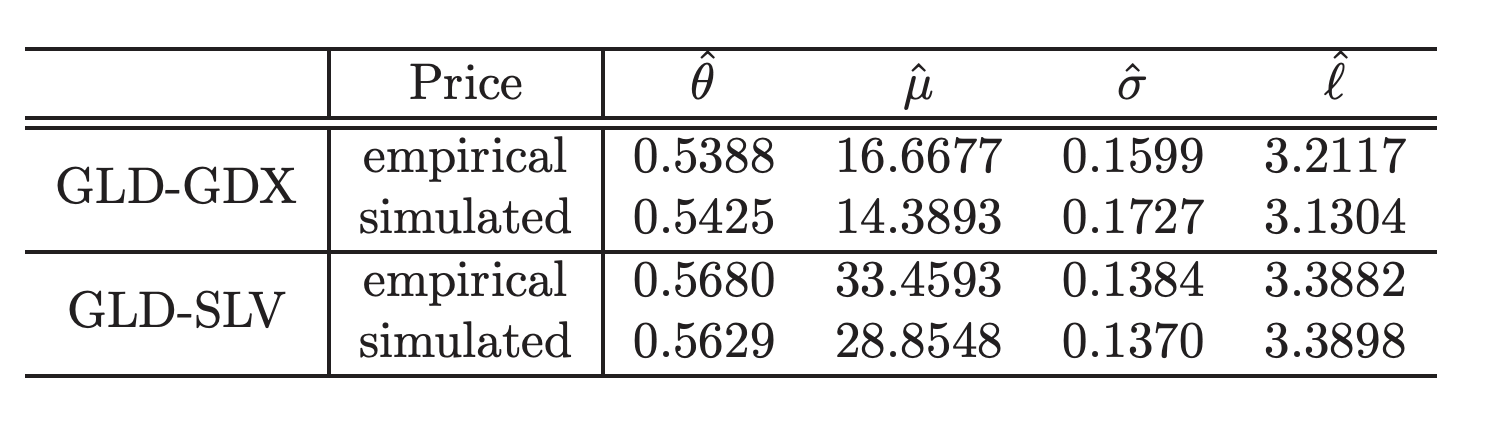

# Solution

\begin{aligned}
& F(x) \equiv F(x ; r):=\int_0^{\infty} u^{\frac{r}{\mu}-1} e^{\sqrt{\frac{2 \mu}{\sigma^2}}(x-\theta) u-\frac{u^2}{2}} d u \\
& G(x) \equiv G(x ; r):=\int_0^{\infty} u^{\frac{r}{\mu}-1} e^{\sqrt{\frac{2 \mu}{\sigma^2}}(\theta-x) u-\frac{u^2}{2}} d u
\end{aligned}

In [121]:
from ou_process import *

import numpy as np
from scipy.integrate import quad
from scipy.optimize import root_scalar

from typing import Callable

import matplotlib.pyplot as plt


def function_F(mu: np.float32,
               sigma: np.float32,
               theta: np.float32,
               r: np.float32) -> Callable[np.float32, np.float32]:
    
    def f(u, x):
        term1 = u**(r/mu - 1)
        term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (x-theta) * u - (u**2)/2 )
        return term1 * term2
    
    def F(x):
        return quad(f, 0, np.inf, args=(x,))[0]

    return F
 
    
def function_F_prime(mu: np.float32,
                     sigma: np.float32,
                     theta: np.float32,
                     r: np.float32) -> Callable[np.float32, np.float32]:
    
    coeff = np.sqrt(2 * mu / sigma**2)
    
    def f_prime(u, x):
        term1 = u**(r/mu)
        term2 = np.exp(coeff * (x - theta) * u - (u**2)/2)
        return term1 * term2 * coeff
    
    def F_prime(x):
        return quad(f_prime, 0, np.inf, args=(x,))[0]

    return F_prime
    

def function_G(mu: np.float32,
               sigma: np.float32,
               theta: np.float32,
               r: np.float32) -> Callable[np.float32, np.float32]:
    
    def g(u, x):
        term1 = u**(r/mu - 1)
        term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (theta-x) * u - (u**2)/2 )
        return term1 * term2
    
    def G(x):
        return quad(g, 0, np.inf, args=(x,))[0]

    return G

def function_G_prime(mu: np.float32,
                     sigma: np.float32,
                     theta: np.float32,
                     r: np.float32) -> Callable[np.float32, np.float32]:
    
    coeff = -np.sqrt(2 * mu / sigma**2)  # Note the negative sign here
    
    def g_prime(u, x):
        term1 = u**(r/mu)
        term2 = np.exp(coeff * (theta - x) * u - (u**2)/2)
        return term1 * term2 * coeff
    
    def G_prime(x):
        return quad(g_prime, 0, np.inf, args=(x,))[0]

    return G_prime

"""
def function_F_prime(mu: np.float32,
                     sigma: np.float32,
                     theta: np.float32,
                     r: np.float32) -> Callable[np.float32, np.float32]:
    
    def f_prime(u, x):
        term1 = u**(r/mu)
        term2 = np.exp( np.sqrt(2*mu/(sigma**2)) * (x-theta) * u - (u**2)/2 )
        return term1 * term2
    
    
    def F_prime(x):
        term3 = np.sqrt(2*mu/(sigma**2))
        return quad(term3 * f_prime, 0, np.inf, args=(x,))[0]
    
    return F_prime


def function_G_prime(mu: np.float32,
                     sigma: np.float32,
                     theta: np.float32,
                     r: np.float32) -> Callable[np.float32, np.float32]:
    
    def g_prime(u, x):
        term1 = u**(r/mu)
        term2 = np.exp( np.sqrt(2*mu/(sigma**2)) * (theta-x) * u - (u**2)/2 )
        return term1 * term2
    
    def G_prime(x):
        term3 = np.sqrt(2*mu/(sigma**2))
        return quad(term3 * g_prime, 0, np.inf, args=(x,))[0]
    
    return G_prime
""" 

def expected_discounted_factor(mu: np.float32,
                                sigma: np.float32,
                                theta: np.float32,
                                r: np.float32,
                                x, 
                                kappa):
    """
    E[e^(-r*tauk)]
    """

    F = function_F(mu=mu, sigma=sigma, theta=theta, r=r)
    G = function_G(mu=mu, sigma=sigma, theta=theta, r=r)

    if x > kappa or x == kappa:
        return G(x)/G(kappa)

    elif x < kappa:
        return F(x)/F(kappa)


def psi(mu: np.float32,
        sigma: np.float32,
        theta: np.float32,
        r: np.float32,
        x):

    F = function_F(mu=mu, sigma=sigma, theta=theta, r=r)
    G = function_G(mu=mu, sigma=sigma, theta=theta, r=r)
    return F(x)/G(x)

In [122]:
def function_V(b : np.float32,
               c : np.float32, 
               F : Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:
    
    """Input b should be b_star"""
    
    def V(x:np.float32) -> Callable[np.float32, np.float32]:
        if x < b:
            return (b-c) * F(x) / F(b)

        else:
            return x-c
    
    return V

def function_V_prime(b: np.float32,
                     c: np.float32,
                     F: Callable[np.float32, np.float32],
                     F_prime: Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:

    def V_prime(x): 
        if x < b:
            return (b - c) * F_prime(x) / F(b)
        else:
            return 1

    return V_prime


def function_J(d: np.float32,
               c: np.float32,
               G: Callable[np.float32, np.float32],
               V: Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:
    
    def J(x: np.float32) -> Callable[np.float32, np.float32]:
        
        if x < d: 
            return V(x) - x - c
        else: 
            return (V(d) - d - c) * G(x) / G(d)
    
    return J


"""
def b_star_finder(x):
    return F(x) - (x - c) * F_prime(x)

def find_b_star(x_init):
    root_result = root_scalar(b_star_finder, bracket=[0,1], x0=x_init)
    b_star = root_result.root
    return b_star, root_result.converged

def d_star_finder(x):
    return (G_prime(x) * (V(x) - x - c)) - (G(x) * (V(x) - 1))

def find_d_star(x_init):
    root_result = root_scalar(d_star_finder, bracket=[0,1], x0=x_init)
    d_star = root_result.root
    return d_star, root_result.converged
"""

def find_b_star(x: np.float32,
                c: np.float32,
                F: Callable[np.float32, np.float32],
                domain: np.array) -> np.float32: 
    
    # Temporary implementation
    i_b_star = np.argmax([function_V(b=b, c=c, F=F)(x) for b in domain]) 
    b_star = domain[i_b_star]
    return b_star

    
def find_d_star(x: np.float32,
                c: np.float32,
                G: Callable[np.float32, np.float32],
                V: Callable[np.float32, np.float32],
                domain: np.array) -> np.float32: 
    
    # Temporary implementation
    i_d_star = np.argmax([function_J(d=d, c=c, G=G, V=V)(x) for d in domain]) 
    d_star = domain[i_d_star]
    return d_star

In [123]:
theta_star, mu_star, sigma_star, mle

(0.5462487824193807,
 14.772816105702846,
 0.16669619339699665,
 3.166379414388735)

In [156]:
x0 = xt[0]
r = 0.05
c = 0.05

F = function_F(mu=mu_star, sigma=sigma_star, theta=theta_star, r=r)
F_prime = function_F_prime(mu=mu_star, sigma=sigma_star, theta=theta_star, r=r)
G = function_G(mu=mu_star, sigma=sigma_star, theta=theta_star, r=r)
G_prime = function_G_prime(mu=mu_star, sigma=sigma_star, theta=theta_star, r=r)

UB = theta_star + 2 * np.std(xt)
LB = theta_star - 2 * np.std(xt)

domain_b = np.linspace(0.4, 1, num=1000, endpoint=True)
b_star = find_b_star(x0,c, F, domain_b)

V = function_V(b=b_star, c=c, F=F)
V_prime = function_V(b=b_star, c=c, F=F)

domain_d = np.linspace(0.4, 1, num=1000, endpoint=True)
d_star = find_d_star(x=x, c=c, G=G, V=V, domain=domain_d)

/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_41336/1286269421.py:23: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(f, 0, np.inf, args=(x,))[0]
/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_41336/1286269421.py:57: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(g, 0, np.inf, args=(x,))[0]


In [152]:
b_star

0.6061065979755773

In [160]:
np.max(xt)

0.6004618825146063

In [164]:
L = theta_star - 2 * np.std(xt)

In [ ]:
0.5938272848756151, 0.4690968492625811)

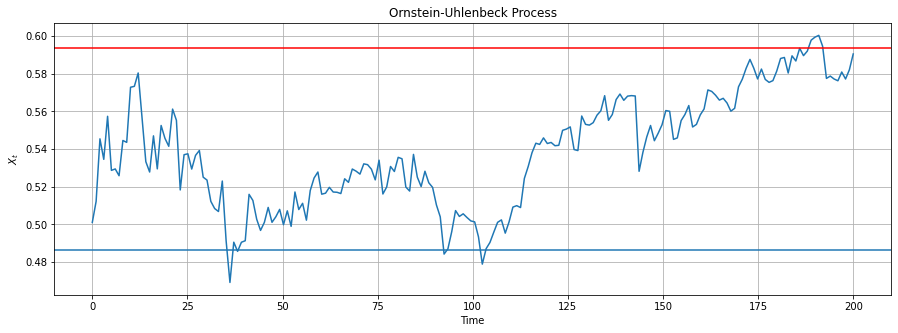

In [165]:
plt.figure(figsize=(15, 5))
plt.plot(t, xt)
plt.axhline(0.5938272848756151, color='r')
plt.axhline(L)
# plt.axhline(L, color='r')
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.title('Ornstein-Uhlenbeck Process')
plt.grid(True)
plt.show()

# Simulated Test

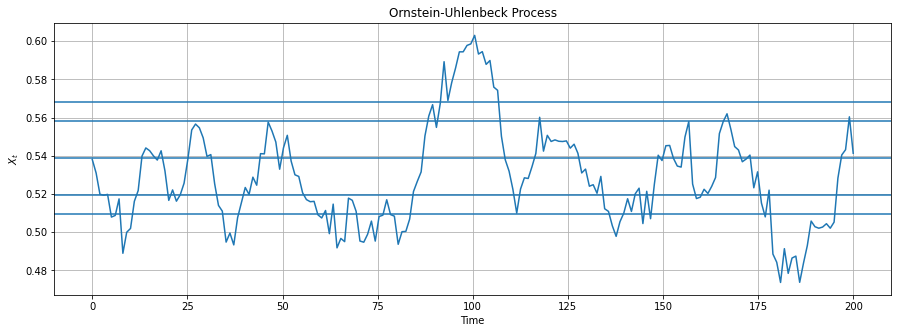

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters and variables
theta = 0.5388
mu = 16.6677
sigma = 0.1599
sigma_tilde = np.sqrt(sigma**2 * (1 - np.exp(-2 * mu * dt)) / (2 * mu))

T = 200       # Total time
dt = 1/252    # Time step
N = 200 # Number of time steps
X0 = 0.538     # Initial value

# Create time array and initialize X array
t = np.linspace(0, T, N)
X = np.zeros(N)
X[0] = X0

# Generate OU process using Euler-Maruyama method
# np.random.seed(0)  # for reproducibility
for i in range(1, N):
    dB = np.sqrt(dt) * np.random.normal()
    dX = mu * (theta - X[i-1]) * dt + sigma * dB
    X[i] = X[i-1] + dX

# Plot the OU process
plt.figure(figsize=(15, 5))
plt.plot(t, X)
plt.axhline(theta)
plt.axhline(theta - 3 * sigma_tilde)
plt.axhline(theta - 2 * sigma_tilde)
plt.axhline(theta + 2 * sigma_tilde)
plt.axhline(theta + 3 * sigma_tilde)
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.title('Ornstein-Uhlenbeck Process')
plt.grid(True)
plt.show()

In [132]:
status = np.zeros_like(X)
cash = np.zeros_like(X)


for i, x in enumerate(X):
    if i == 0:
        continue
        
    if (status[i - 1] == 1) and (x >= mean - std_close):
        status[i] = 0
        cash[i] += x * (1 + TC)
    elif (status[i - 1] == -1) and (x <= mean + std_close):
        status[i] = 0
        cash[i] -= x * (1 + TC)
    elif (status[i - 1] == 0) and (x >= mean + std_open):
        status[i] = -1
        cash[i] += x * (1 + TC)
    elif (status[i - 1] == 0) and (x <= mean - std_open):
        status[i] = 1
        cash[i] -= x * (1 + TC)
    else:
        status[i] = status[i - 1]

0 0.538
1 0.5498278834317862
2 0.538231308942959
3 0.5337355233009118
4 0.5310358680487063
5 0.5463119829752203
6 0.5524796982944646
7 0.5459398603837582
8 0.5213184357816233
9 0.5172839719870785
10 0.5215901972142477
11 0.5340791974322437
12 0.5400645724073225
13 0.5511481746858099
14 0.554696040917949
15 0.5555543832959309
16 0.5403619382101955
17 0.5524272817331747
18 0.543008227028822
19 0.547684597274497
20 0.5462446019238298
21 0.5429339573689941
22 0.5474488124920096
23 0.5382891408976462
24 0.5484424377641152
25 0.5619080305029209
26 0.5635909874742131
27 0.5440682338971276
28 0.5433170002203748
29 0.5477201621494049
30 0.5604847366881516
31 0.5444036985407545
32 0.556073691246717
33 0.5588423639779655
34 0.5605937244636512
35 0.5743913218628417
36 0.578809977195024
37 0.5762872127352733
38 0.5952730348175659
39 0.5852642023493406
40 0.5685768188015796
41 0.5781993990643675
42 0.5720179731693278
43 0.5801011620520333
44 0.5809395701916992
45 0.5666661035724845
46 0.565690617560

In [115]:
from scipy.integrate import quad
from scipy.optimize import root_scalar
import numpy as np

# Parameters
mu = 16.6677
sigma = 0.1599
theta = 0.5388
x_init = 0.538
r = 0.05
c = 0.05

# Define the function F(x)
def integrand_F(u, x):
    return u ** (r / mu - 1) * np.exp(np.sqrt(2 * mu / sigma**2) * (x - theta) * u - u**2 / 2)

def F(x):
    integral, _ = quad(integrand_F, 0, np.inf, args=(x), limit=1000, epsabs=1e-12, epsrel=1e-12)
    return integral

# Define the derivative F'(x)
def integrand_F_prime(u, x):
    return np.sqrt(2 * mu / sigma**2) * u ** (r / mu) * np.exp(np.sqrt(2 * mu / sigma**2) * (x - theta) * u - u**2 / 2)

def F_prime(x):
    integral, _ = quad(integrand_F_prime, 0, np.inf, args=(x), limit=1000, epsabs=1e-12, epsrel=1e-12)
    return integral

# Define the function G(x)
def integrand_G(u, x):
    return u ** (r / mu - 1) * np.exp(np.sqrt(2 * mu / sigma**2) * (theta - x) * u - u**2 / 2)

def G(x):
    integral, _ = quad(integrand_G, 0, np.inf, args=(x), limit=1000, epsabs=1e-12, epsrel=1e-12)
    return integral

# Define the derivative G'(x)
def integrand_G_prime(u, x):
    return -np.sqrt(2 * mu / sigma**2) * u ** (r / mu) * np.exp(np.sqrt(2 * mu / sigma**2) * (theta - x) * u - u**2 / 2)

def G_prime(x):
    integral, _ = quad(integrand_G_prime, 0, np.inf, args=(x), limit=1000, epsabs=1e-12, epsrel=1e-12)
    return integral

# Define V(x) and its derivative V'(x)
def V(x):
    if x < b_star:  # Assuming b_star is the breaking point for the piecewise function
        return (b_star - c) * F(x) / F(b_star)
    else:
        return x - c

def V_prime(x):
    if x < b_star:
        return (b_star - c) * F_prime(x) / F(b_star)
    else:
        return 1

# Root-finding for b_star
def root_function_b_star(x):
    return F(x) - (x - c) * F_prime(x)

root_result_b_star = root_scalar(root_function_b_star, bracket=[0, 1], x0=x_init)
b_star = root_result_b_star.root

# Root-finding for d_star
def root_function_d_star(d):
    return G(d) * (V_prime(d) - 1) - G_prime(d) * (V(d) - d - c)

root_result_d_star = root_scalar(root_function_d_star, bracket=[0, 1], x0=x_init)
d_star = root_result_d_star.root

b_star, d_star


/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_41336/1756584422.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral, _ = quad(integrand_F, 0, np.inf, args=(x), limit=1000, epsabs=1e-12, epsrel=1e-12)
/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_41336/1756584422.py:34: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral, _ = quad(integrand_G, 0, np.inf, args=(x), limit=1000, epsabs=1e-12, epsrel=1e-12)


(0.5937094348460092, 0.4481915635130346)

In [116]:
L

0.48639096686318406

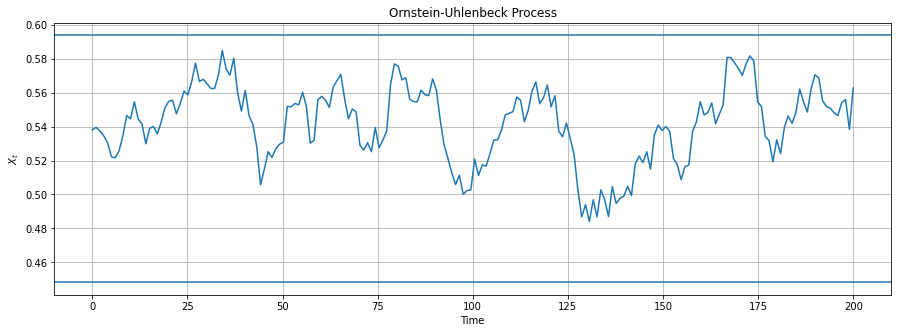

In [48]:
plt.figure(figsize=(15, 5))
plt.plot(t, X)
plt.axhline(b)
plt.axhline(d)
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.title('Ornstein-Uhlenbeck Process')
plt.grid(True)
plt.show()


In [119]:
from math import sqrt, exp
import scipy.integrate as si
import scipy.optimize as so
import numpy as np

def Prime(f, x, theta, mu, sigma, r, h=1e-5):
    # given f, estimates f'(x) using the difference quotient formula 
    # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
    return (f(x+h, theta, mu, sigma, r) - f(x, theta, mu, sigma, r)) / h 

def Prime2(f, x, theta, mu, sigma, r, c, h=1e-5):
    # given f, estimates f'(x) using the difference quotient formula 
    # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
    return (f(x+h, theta, mu, sigma, r, c) - f(x, theta, mu, sigma, r, c)) / h 

def F(x, theta, mu, sigma, r):
    # equation 3.3
    def integrand(u):
        return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (x-theta)*u - u**2/2)
    return si.quad(integrand, 0, np.inf)[0]

def G(x, theta, mu, sigma, r):
    # equation 3.4
    def integrand(u):
        return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (theta-x)*u - u**2/2)
    return si.quad(integrand, 0, np.inf)[0]

def b_star(theta, mu, sigma, r, c):
    # estimates b* using equation 4.3
    # def opt_func(b):
    #     # equation 4.3 in the paper with terms moved to one side
    #     return abs(F(b, theta, mu, sigma, r) - (b-c)*Prime(F, b, theta, mu, sigma, r))
    # bounds = ((.01, .99),)
    # result = so.minimize(opt_func, .5, bounds=bounds)

    b_space = np.linspace(0.1,0.9, 801)
    def func(b):
        return F(b, theta, mu, sigma, r) - (b-c)*Prime(F, b, theta, mu, sigma, r)
    
    return so.brentq(func, 0, 1)

def V(x, theta, mu, sigma, r, c):
    # OUR SELL SIGNAL
    # equation 4.2, solution of equation posed by 2.3
    
    b_star_val = b_star(theta, mu, sigma, r, c)
    
    if x < b_star_val:
        return (b_star_val - c) * F(x, theta, mu, sigma, r) / F(b_star_val, theta, mu, sigma, r)
    else:
        return x - c

def d_star(theta, mu, sigma, r, c):
    # estimates d* using equation 4.11
  
    def func(d):
        return (G(d, theta, mu, sigma, r) * (Prime2(V, d, theta, mu, sigma, r, c) - 1)) - (Prime(G, d, theta, mu, sigma, r) * (V(d, theta, mu, sigma, r, c) - d - c))

    # finds the root between the interval [0, 1]
    return so.brentq(func, 0, 1)
    

In [120]:
r = c = .05
b = b_star(theta, mu, sigma, r, c)
d = d_star(theta, mu, sigma, r, c)
b, d  # our optima

/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_41336/2808102034.py:20: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(integrand, 0, np.inf)[0]
/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_41336/2808102034.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(integrand, 0, np.inf)[0]


(0.593704434621312, 0.44818657037854703)

In [ ]:
F = function_F(mu=mu, sigma=sigma, theta=theta, r=r)
F_prime = function_F_prime(mu=mu, sigma=sigma, theta=theta, r=r)
G = function_G(mu=mu, sigma=sigma, theta=theta, r=r)
G_prime = function_G_prime(mu=mu, sigma=sigma, theta=theta, r=r)

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(t, X)
plt.axhline(b_star)
plt.axhline(d_star)
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.title('Ornstein-Uhlenbeck Process')
plt.grid(True)
plt.show()

In [ ]:
def b_star_finder(x):
    return F(x) - (x - c) * F_prime(x)

def find_b_star(x_init, max_value):
    root_result = root_scalar(b_star_finder, bracket=[0,max_value], x0=x_init)
    b_star = root_result.root
    return b_star, root_result.converged

def d_star_finder(x):
    return (G_prime(x) * (V(x) - x - c)) - (G(x) * (V(x) - 1))

def find_d_star(x_init):
    root_result = root_scalar(d_star_finder, bracket=[0,1], x0=x_init)
    d_star = root_result.root
    return d_star, root_result.converged


find_b_star(X[0],np.max(X))

### Finding candidate interval [a, b]

In [24]:
from scipy.optimize import minimize
import numpy as np
from typing import Tuple

def function_h(x, c):
    """Reward Function"""
    def h(x, c):
        return x-c
    return h


def test_expected_discounted_factor(x: np.float32, a: np.float32, b: np.float32, F, G):
    """
    test_expected_discounted_factor(a_star, b_star, a_star, F, G) # (1, 0)
    test_expected_discounted_factor(b_star, a_star, b_star, F, G) # (0, 1)
    """
    if x <= a:
        exp_a = F(x) / F(a)
        exp_b = 0  # As it's certain that tau_a < tau_b in this case
    elif x >= b:
        exp_a = 0  # As it's certain that tau_a > tau_b in this case
        exp_b = G(x) / G(b)
    else:
        exp_a = F(x) / F(a)
        exp_b = G(x) / G(b)
    return exp_a, exp_b


def expected_discounted_reward(params: Tuple[np.float32, np.float32], x: np.float32, h, F, G) -> np.float32:
    a, b = params
    
    if x <= a:
        exp_a = F(x) / F(a)
        exp_b = 0  # As it's certain that tau_a < tau_b in this case
    elif x >= b:
        exp_a = 0  # As it's certain that tau_a > tau_b in this case
        exp_b = G(x) / G(b)
    else:
        exp_a = F(x) / F(a)
        exp_b = G(x) / G(b)

    return -(h(a) * exp_a + h(b) * exp_b)


def find_optimal_interval(F,
                          G,
                          r: np.float32,
                          c: np.float32,
                          x: np.float32) -> Tuple[np.float32, np.float32]:
    
    h = lambda z: z - c

    # Optimize for a and b jointly
    initial_guess = [x - 0.1, x + 0.1]  # Replace with more educated guesses if available
    # initial_guess = [0.4690968492625811, 0.6004618825146063] # np.min(xt), np.max(xt)
    bounds = [(-np.inf, np.inf), (-np.inf, np.inf)]  # Replace with actual bounds if available
    
    result = minimize(expected_discounted_reward, initial_guess, args=(x, h, F, G), bounds=bounds)
    
    a_star, b_star = result.x
    
    return a_star, b_star

F = function_F(mu=mu_star, sigma=sigma_star, theta=theta_star, r=r)
F_prime = function_F_prime(mu=mu_star, sigma=sigma_star, theta=theta_star, r=r)
G = function_G(mu=mu_star, sigma=sigma_star, theta=theta_star, r=r)
G_prime = function_G_prime(mu=mu_star, sigma=sigma_star, theta=theta_star, r=r)


xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
x = xt[0]
theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)
r = 0.05
c = 0.05

a_star, b_star = find_optimal_interval(F,G, r, c, x)

print("Optimal Interval [a, b]:", "[{}, {}]".format(a_star, b_star))


/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_41336/1286269421.py:23: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(f, 0, np.inf, args=(x,))[0]
/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_41336/1286269421.py:19: RuntimeWarning: overflow encountered in exp
  term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (x-theta) * u - (u**2)/2 )


Optimal Interval [a, b]: [0.500999909006066, 0.7063011323304208]


In [ ]:
# Same example 
GDX = pd.read_csv('data/GDX_historical.csv')
GLD = pd.read_csv('data/GLD_historical.csv')
SLV = pd.read_csv('data/SLV_historical.csv')

gld = GLD['Adj Close'].to_numpy()
gdx = GDX['Close'].to_numpy()
slv = SLV['Close'].to_numpy()

M = 3
gld = gld[M:M + 200]
gdx = gdx[M:M + 200]
slv = slv[M:M + 200]

N = gld.size
dt = 1/252

table1 = get_mle_table(gld, gdx, dt)
table2 = get_mle_table(gld, slv, dt)

B = np.linspace(0.3, 1, 500)
B_star_gld_gdx = get_B_star(table1)
B_star_gld_slv = get_B_star(table2)

xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)

xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
x = xt[0]
theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)
# theta = 0.5388
# mu = 16.6677
# sigma = 0.1599
r = 0.05
c = 0.05

F = function_F(mu=mu, sigma=sigma, theta=theta, r=r)
F_prime = function_F_prime(mu=mu, sigma=sigma, theta=theta, r=r)
G = function_G(mu=mu, sigma=sigma, theta=theta, r=r)
G_prime = function_G_prime(mu=mu, sigma=sigma, theta=theta, r=r)

candidate_a, candidate_b = find_optimal_interval(F, G, r, c, x)
# print("Optimal Interval [a, b]:", "[{}, {}]".format(candidate_a, candidate_b))

# plot V(x) against b
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("V(x) against b")
plt.xlabel("b (liquidation level), d (entry level)")
plt.ylabel("V(x) (value of liquidation)")
plt.ylim([0, 2])
plt.axvline(x=x, color='k', linestyle='--')
plt.axhline(y=x, color='k', linestyle='--')

domain = np.linspace(candidate_a, candidate_b, num=1000, endpoint=True)

l_V = plt.plot(domain, [function_V(b=b, c=c, F=F)(x) for b in domain], color='r', label="V(x)")

b_star = find_b_star(x=x, c=c, F=F, domain=domain)
plt.axvline(x=b_star, color='k', linestyle='--')
plt.text(b_star, 0 ,f"{b_star.round(4)}")
l_diff = plt.plot(domain,
                [np.log(np.log(abs(F(b_star) - (b_star - 0) * F_prime(b_star)))) for b_star in domain],  # to rescale
                color='b',
                label="F(b) - (b - c) * F'(b)")
plt.legend()

# plot J(x) against d
plt.subplot(1, 2, 2)
plt.title("J(x) against d")
plt.xlabel("d (entry level)")
plt.ylabel("J(x) (value of entry)")
plt.ylim([0, 2])

V = function_V(b=b_star, c=c, F=F)
V_prime = function_V(b=b_star, c=c, F=F)

plt.plot(domain,
        [function_J(d=d, c=c, G=G, V=V)(x) for d in domain],
        color='r',
        label="J(x)")
d_star = find_d_star(x=x, c=c, G=G, V=V, domain=domain)
plt.axvline(x=d_star, color='k', linestyle='--')
plt.text(d_star, 0 ,f"{d_star.round(4)}")
plt.axvline(x=x, color='k', linestyle='--')
plt.text(0, V(x) - x - c + 0.01 ,f"V(x) - x - c")
plt.text(x  + 0.01, 0,f"x={x}")
plt.plot(domain,
        [np.log(np.log(abs(G(d) * (V_prime(d) - 1) - (G_prime(d) * (V(d) - d -c))))) for d in domain], # to rescale
        color='b',
        label="G(d) * (V'(d) - 1) - (G'(d) * (V(d) - d -c)")
plt.legend()
plt.show()

In [ ]:
print(candidate_a)
print(b_star)
print(candidate_b)
print(d_star)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(xt,'--', label='GLD-GDX')
plt.axhline(b_star, color = 'g', label='b_star')
plt.axhline(d_star, color = 'r', label='d_star')
plt.legend()

In [ ]:
def strategy(X, mean, std_open=0.5, std_close=0.05, TC=0):
    """Implementation of the strategy.
        - std_open = levels for opening the position.
        - std_close = levels for closing the position.
        - TC = Transaction costs
    Returns:
        - status:  at each time says if we are long=1, short=-1 or we have no open positions = 0
        - cash: the cumulative amount of cash gained by the strategy.
        At terminal time if there is an open position, it is closed.
    """
    X0 = X[0]
    status = np.zeros_like(X)
    cash = np.zeros_like(X)
    cash[0] = X0
    for i, x in enumerate(X):
        if i == 0:
            continue
        if (status[i - 1] == 1) and (x >= mean - std_close):
            status[i] = 0
            cash[i] += x * (1 + TC)
        elif (status[i - 1] == -1) and (x <= mean + std_close):
            status[i] = 0
            cash[i] -= x * (1 + TC)
        elif (status[i - 1] == 0) and (x >= mean + std_open):
            status[i] = -1
            cash[i] += x * (1 + TC)
        elif (status[i - 1] == 0) and (x <= mean - std_open):
            status[i] = 1
            cash[i] -= x * (1 + TC)
        else:
            status[i] = status[i - 1]

    if status[-1] == 1:
        cash[-1] += x * (1 + TC)
    if status[-1] == -1:
        cash[-1] -= x * (1 + TC)

    return status, cash.cumsum()

In [ ]:
strategy(xt, mean=theta)

In [ ]:
mu - 